In [1]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [2]:
filename = 'LIC_Model_Input.csv'

df = pd.read_csv(filename)

df.head().T

,0,1,2,3,4
ApprovalFY,2006,1997,1997,2005,1997
Term,264,60,120,35,60
NoEmp,9,2,4,3,2
NewBiz,0,0,0,0,0
RevLineCr,0,0,0,0,0
LowDoc,0,1,0,0,1
DisbursementGross,1.5242e+06,90000,59000,50000,21200
MIS_Status,P I F,P I F,P I F,CHGOFF,P I F
TotalLoansInCounty,445,445,445,445,445
PIF_RateByCounty,0.876404,0.876404,0.876404,0.876404,0.876404


In [3]:
# First I want to try a classifier without the categorical variable of Industry:

df = df.drop(columns='Industry')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19298 entries, 0 to 19297
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ApprovalFY          19298 non-null  int64  
 1   Term                19298 non-null  int64  
 2   NoEmp               19298 non-null  int64  
 3   NewBiz              19298 non-null  float64
 4   RevLineCr           19183 non-null  float64
 5   LowDoc              19242 non-null  float64
 6   DisbursementGross   19298 non-null  float64
 7   MIS_Status          19293 non-null  object 
 8   TotalLoansInCounty  19298 non-null  int64  
 9   PIF_RateByCounty    19298 non-null  float64
 10  MedIncome           19298 non-null  int64  
 11  PopChange           19298 non-null  float64
 12  EmployedInCty       19298 non-null  int64  
 13  UnempInCty          19298 non-null  int64  
 14  UnempRateInCty      19298 non-null  float64
 15  DeathsPer100k       18970 non-null  object 
 16  PayD

In [5]:
# Replace MIS_Status column with 0's and 1's. 1 corresponds to a loan default. 

df['MIS_Status'] = df.MIS_Status.replace(to_replace=['P I F', 'CHGOFF'], value=[1, 0])

In [6]:
# There appear to be several null values in the DeathsPer100k column turnign it into an object. 
df.DeathsPer100k.describe()

count     18970
unique       59
top       823.4
freq       3635
Name: DeathsPer100k, dtype: object

In [7]:
# Python is treating this column like string objects:
df.DeathsPer100k.value_counts().tail()

1372.6                 4
616.2                  2
1048.1 (Unreliable)    1
1146.6                 1
537.9 (Unreliable)     1
Name: DeathsPer100k, dtype: int64

In [8]:
# The object assignments comes from all the (Unreliable) numbers, so we will force these into numbers:

df['DeathsPer100k'] = pd.to_numeric(df['DeathsPer100k'], errors='coerce')
df['DeathsPer100k'].fillna((df['DeathsPer100k'].mean()), inplace=True)

In [9]:
df.DeathsPer100k.describe()

count    19298.000000
mean       625.524481
std        194.370452
min        160.800000
25%        551.900000
50%        565.800000
75%        823.400000
max       1372.600000
Name: DeathsPer100k, dtype: float64

In [10]:
# To review, about 17% of the loans in this dataset are defaulted, as seen below. 
df.MIS_Status.value_counts()

1.0    15925
0.0     3368
Name: MIS_Status, dtype: int64

In [11]:
df.shape

(19298, 17)

In [12]:
df = df.dropna()
df.shape

(19084, 17)

We'll start with a Dummy Classifier model based on stratification, then move to a simple Logistic regression model:

In [13]:
# Load libraries:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score


In [14]:
# Split the dataset into features and target:
y = df['MIS_Status']
X = df.drop(columns='MIS_Status')

In [15]:
# Standardizr the various features in the dataset, since different variables have different ranges:

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [16]:
# Create training and test data

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

In [17]:
# Dummy model based on stratificaation:

dummy = DummyClassifier(strategy='stratified', random_state=13)

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.7015981137018601

In [18]:
# We create target probabilities for the predicted values of y:

target_probabilities = dummy.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

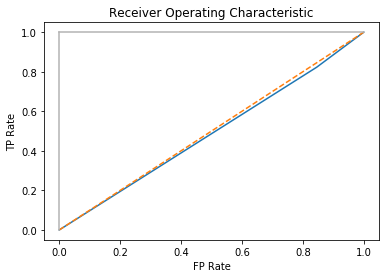

In [19]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

In [20]:
# Dummy model based on assuming that ALL loan are good loans! I.e., a constant value of 1:

dummy = DummyClassifier(strategy='constant', constant = 1)

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.8184438040345822

In [21]:
# We create target probabilities for the predicted values of y:

target_probabilities = dummy.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

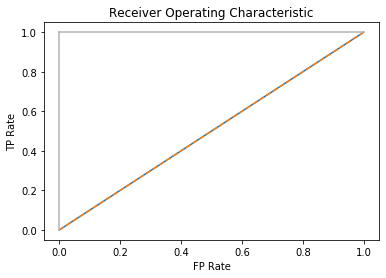

In [22]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

#### Logistic Regression ####

While the accuracy values of the dummy models were not that bad (the data are skewed towards loans being good, after all);  
Now we will explore Logistic Regression:

In [23]:
# Create a simple logistic regression model object and fit the training data

logit = LogisticRegression()

model = logit.fit(X_train, y_train)

In [24]:
# Accuracy score

model.score(X_test, y_test)

0.8784385643175269

In [25]:
# Make predictions for the test data set:
y_pred = model.predict(X_test)

In [26]:
# Generate a confusion matrix
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

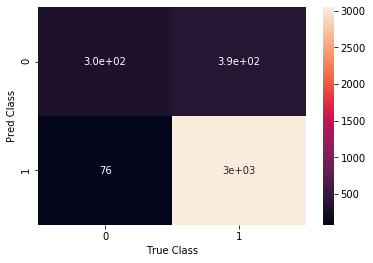

In [27]:
sns.heatmap(matrix, annot=True)
plt.xlabel('True Class'), plt.ylabel('Pred Class')
plt.show()

In [28]:
# F1 score is pretty good, but AUC is only 71% or so:

print(f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred))

0.9292682926829268 0.7078938276121375


In [29]:
# We again create target probabilities for the predicted values of y:

target_probabilities = logit.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

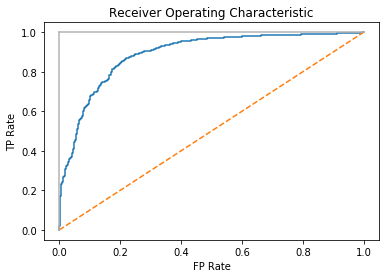

In [30]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

#### Random Forest Classifier ####

Next we'll explore a Random Forest classifier model to see if it can do a better job than the logistic regression:


In [31]:
# Load Random Forest library
from sklearn.ensemble import RandomForestClassifier


In [33]:
randomforest = RandomForestClassifier(random_state=17, n_jobs=-1)

rfmodel = randomforest.fit(X_train, y_train)

In [34]:
y_predrf = rfmodel.predict(X_test)

In [35]:
# F1 score is pretty good, but AUC is only 71% or so:

print(f1_score(y_test, y_predrf), roc_auc_score(y_test, y_predrf))

0.9612305760477162 0.8565991911062333


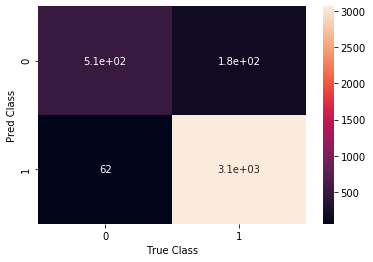

In [36]:
# Generate a confusion matrix
rfmatrix = pd.DataFrame(confusion_matrix(y_test, y_predrf))

sns.heatmap(rfmatrix, annot=True)
plt.xlabel('True Class'), plt.ylabel('Pred Class')
plt.show()

In [37]:
# We again create target probabilities for the predicted values of y:

rf_target_probabilities = rfmodel.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, rf_target_probabilities)

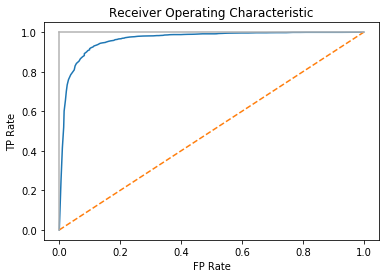

In [38]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()